In [1]:
# import jax.numpy as np
# from jax import grad, value_and_grad, jit, ops
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

SyntaxError: invalid syntax (gamma_SSN_losses.py, line 316)

In [ ]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [ ]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, r_fp

In [ ]:
params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5, 1.3, 2.4, 1.0, 1.0, 1.0, 0.6])
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [ ]:
x = np.linspace(-20, 95, 1000)

lower_bound = 5
upper_bound = 80
kink_control = 1

ufx = losses.myReLu((x - upper_bound)/kink_control)
lfx = losses.myReLu((-lower_bound -x)/ kink_control)

# ufx = np.log(1 + np.exp((x - upper_bound)/kink_control)) 
# lfx = np.log(1 + np.exp((-x -lower_bound)/kink_control))
plt.plot(x, lfx+ufx)

In [ ]:
import numpy as onp

x = np.linspace(-30, 30, 10000)
cons = len(test_contrasts)
target_rates = 5*onp.ones((2, cons))
upper_bound_rates = onp.zeros((2, cons))
lower_bound_rates = onp.zeros((2, cons))
half_width_rates = 20
kink_control = 5


rates_range = np.linspace(-30, 100, 1000)
for ei in [0,1]:
    for con in np.arange(cons):
        error_range = target_rates[ei, con] - rates_range
        if target_rates[ei, con] - half_width_rates < 0:
            lower_half_width = target_rates[ei, con]
        else:
             lower_half_width = half_width_rates
        
        lower_curve = losses.myReLu((error_range - lower_half_width)/kink_control)
        higher_curve = losses.myReLu((-error_range - half_width_rates)/kink_control)
        
        upper_bound_rates[ei, con] = np.max(rates_range[higher_curve+lower_curve < 0.5])
        lower_bound_rates[ei, con] = np.min(rates_range[higher_curve+lower_curve < 0.5])

        

# upper_bound = losses.myReLu((error_range - half_width_rates)/kink_control)
# lower_bound = losses.myReLu((-error_range - half_width_rates)/kink_control)

e_error = np.vstack(([-lower_bound_rates[0,:]], [upper_bound_rates[0,:]])) 
i_error = np.vstack(([-lower_bound_rates[1,:]], [upper_bound_rates[1,:]])) 

# plt.plot(rates_range, upper_bound + lower_bound)
# plt.plot(x, yy)
fig, ax = plt.subplots(1,1)
ax.plot(test_contrasts, upper_bound_rates.T)
ax.set_prop_cycle(None)
ax.plot(test_contrasts, lower_bound_rates.T)



In [ ]:
# target_rates = losses.get_target_rates()
# rates_error = target_rates - r_fp
# # lower_bound_rates = losses.myReLu(half_width_rates/kink_control)
# # upper_bound_rates = losses.myReLu(-half_width_rates/kink_control)

# fig_rates, ax_rates = plt.subplots(1,1)
# ax_rates.plot(test_contrasts, target_rates.T, "--")
# #colrs = ax.get_color_cycle()
# ax_rates.set_prop_cycle(None)
# # ax_rates.plot(test_contrasts, r_fp.T)
# ax_rates.set_prop_cycle(None)
# # ax_rates.plot(test_contrasts, lower_bound_rates.T, '^')
# # ax_rates.set_prop_cycle(None)
# # ax_rates.plot(test_contrasts, upper_bound_rates.T, '^')
# # ax_rates.errorbar(test_contrasts, r_fp[0,:].T, np.array([[upper_bound_rates[0,:]], [lower_bound_rates[0,:]]]) )
# plt.errorbar(test_contrasts,r_fp[0,:], yerr=(e_error), fmt='')
# ax_rates.set_title('post gradient descent')
# ax_rates.set_ylabel('Firing Rate (Hz)')
# ax_rates.set_xlabel('Contrast')

# # plt.plot(test_contrasts,r_fp.T)

Text(0.5, 1.0, 'I Rates')

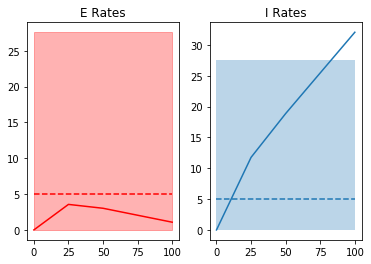

In [8]:
fig_split, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(test_contrasts, target_rates[0,:], "r--")
ax1.set_prop_cycle(None)
ax1.plot(test_contrasts, r_fp[0,:],"r")
# ax1.fill_between(test_contrasts, r_fp[0,:] + e_error[1,:], r_fp[0,:] - np.abs(e_error[0,:]), color='r', alpha=0.3)
ax1.fill_between(test_contrasts, target_rates[0,:] + e_error[1,:], 0, color='r', alpha=0.3)
ax1.set_title('E Rates')

ax2.plot(test_contrasts, target_rates[1,:], "--")
ax2.set_prop_cycle(None)
ax2.plot(test_contrasts, r_fp[1,:])
# ax2.fill_between(test_contrasts, r_fp[1,:] + i_error[1,:], r_fp[1,:] - np.abs(i_error[0,:]), alpha=0.3)
ax2.fill_between(test_contrasts, target_rates[1,:] + i_error[1,:], 0, alpha=0.3)
ax2.set_title('I Rates')

# Re-Tool Errors

So I have some code that keeps the rates bound between 0 and 80. But now I want to think about how to incorporate errors into that (AKA difference between the expected rates and the observed rates).

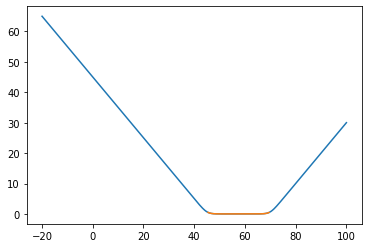

In [29]:
rr = np.linspace(-20, 100, 1000)
ideal_r = 50

low_bound = 5
upper_bound = 20
kink_control = 1

yy = losses.rates_error_fcn(-1*(ideal_r - rr), low_bound, upper_bound, kink_control)
zero_ind = np.where(yy < 0.5)
plt.plot(rr, yy, rr[zero_ind], yy[zero_ind])


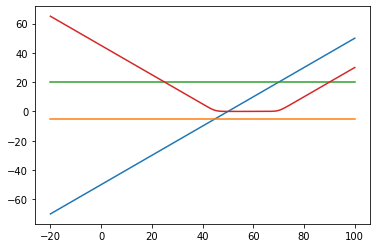

In [30]:
plt.plot(rr, -1*(ideal_r - rr), rr, -low_bound*np.ones(len(rr)), rr, upper_bound*np.ones(len(rr)), rr, yy)

In [31]:
rr[zero_ind]

array([45.46546547, 45.58558559, 45.70570571, 45.82582583, 45.94594595,
       46.06606607, 46.18618619, 46.30630631, 46.42642643, 46.54654655,
       46.66666667, 46.78678679, 46.90690691, 47.02702703, 47.14714715,
       47.26726727, 47.38738739, 47.50750751, 47.62762763, 47.74774775,
       47.86786787, 47.98798799, 48.10810811, 48.22822823, 48.34834835,
       48.46846847, 48.58858859, 48.70870871, 48.82882883, 48.94894895,
       49.06906907, 49.18918919, 49.30930931, 49.42942943, 49.54954955,
       49.66966967, 49.78978979, 49.90990991, 50.03003003, 50.15015015,
       50.27027027, 50.39039039, 50.51051051, 50.63063063, 50.75075075,
       50.87087087, 50.99099099, 51.11111111, 51.23123123, 51.35135135,
       51.47147147, 51.59159159, 51.71171171, 51.83183183, 51.95195195,
       52.07207207, 52.19219219, 52.31231231, 52.43243243, 52.55255255,
       52.67267267, 52.79279279, 52.91291291, 53.03303303, 53.15315315,
       53.27327327, 53.39339339, 53.51351351, 53.63363363, 53.75